In [ ]:
from transformers import AutoConfig

# Load original config
config = AutoConfig.from_pretrained("asafaya/bert-base-arabic", num_labels=3)

# Save it into your checkpoint folder
config.save_pretrained("results/checkpoint-90")

In [39]:
from datasets import load_dataset
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

ds = load_dataset("Qanadil/ArSAS_An_Arabic_Speech-Act_and_Sentiment_Corpus_of_Tweets")
split_ds = ds['train'].train_test_split(test_size=0.3, seed=42)

train_ds = split_ds['train']
val_ds = split_ds['test']

tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

def tokenize(example):
    return tokenizer(example["Tweet_text"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

def fix_labels(example):
    label_mapping = {"Positive": 0, "Neutral": 1, "Negative": 2}
    example["Sentiment_label"] = label_mapping[example["Sentiment_label"]]
    return example

# Apply the label fix
train_ds = train_ds.map(fix_labels)
val_ds = val_ds.map(fix_labels)

train_ds = train_ds.rename_column("Sentiment_label", "labels")
val_ds = val_ds.rename_column("Sentiment_label", "labels")

train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [40]:
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "results/checkpoint-180"  # The path where the model was saved after training
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model = model.to(device)
model.eval()

val_loader = DataLoader(val_ds, batch_size=32)
trn_loader = DataLoader(train_ds, batch_size=32)

all_preds = []
all_labels = []

val_preds = []
val_labels = []

with torch.no_grad():
    for batch in trn_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Calculate metrics
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

vacc = accuracy_score(val_labels, val_preds)
vf1 = f1_score(val_labels, val_preds, average='weighted')

print(f"Training Accuracy: {acc:.4f}")
print(f"Training F1 Score: {f1:.4f}")

print(f"Test Accuracy: {vacc:.4f}")
print(f"Test F1 Score: {vf1:.4f}")

Training Accuracy: 0.8444
Training F1 Score: 0.8429
Test Accuracy: 0.8032
Test F1 Score: 0.8020


In [ ]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

model_path = "results/checkpoint-90"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

# Initialize the pipeline for text classification on GPU
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

# Your own text to test
input_text = "المكان بحالة سيئة"

# Get predictions
predictions = classifier(input_text)

# Display the prediction
print(predictions) # {"Positive": 0, "Neutral": 1, "Negative": 2}


Device set to use cuda:0


[{'label': 'LABEL_0', 'score': 0.7305986881256104}]


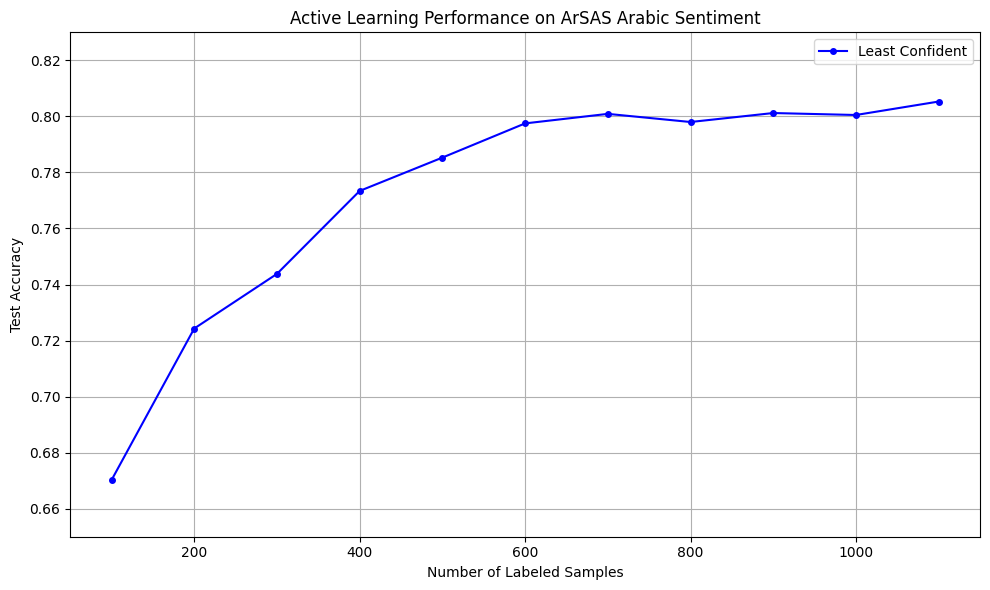

In [5]:
import matplotlib.pyplot as plt

# Data
samples = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100]
test_accuracy = [0.6702, 0.7243, 0.7438, 0.7734, 0.7853, 0.7975, 0.8009, 0.7980, 0.8012, 0.8005, 0.8053]

# Plot
plt.figure(figsize=(10,6))
plt.plot(samples, test_accuracy, marker='o', linestyle='-', color='b', markersize=4, label='Least Confident')

# Labels and title
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Test Accuracy')
plt.title('Active Learning Performance on ArSAS Arabic Sentiment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(0.65, 0.83)

plt.show()
